<a href="https://colab.research.google.com/github/ap1809/TweetSense/blob/main/Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Loading Dataset**

In [2]:
train_set = pd.read_csv("/content/train.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

test_set = pd.read_csv("/content/test.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)


In [3]:
train_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
test_set.head(n = 5).style.background_gradient(cmap = "viridis")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [5]:
print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))

Train set shape: (31962, 3) and test set shape: (17197, 2)


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
print("Duplicated items - {}".format(train_set.duplicated().sum()))

Duplicated items - 0


In [8]:
train_set.groupby("label").count().style.background_gradient(cmap = "summer")

,id,tweet
label,,
0,29720,29720
1,2242,2242


**Data Preprocessing**

In [9]:
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [10]:
train_set["tweet"] = train_set["tweet"].str.replace('[^\w\s]','')
test_set["tweet"] = test_set["tweet"].str.replace('[^\w\s]','')

In [11]:
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')

In [12]:
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [13]:
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [14]:
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)

In [15]:
train_set.head(n = 10)

,label,tweet
0,0,user father dysfunctional selfish drag kid dys...
1,0,user user thanks lyft credit cant use cause do...
2,0,bihday majesty
3,0,model love u take u time urð ðððð ððð
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,user camping tomorrow user user user user user...
7,0,next school year year examsð cant think ð scho...
8,0,love land allin cavs champion cleveland clevel...
9,0,user user welcome im gr


In [16]:
test_set.head(n = 10)

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacist want everyone see new â...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes ð...
4,rd bihday amazing hilarious nephew eli ahmir u...
5,choose momtips
6,something inside dy ððâ eye ness smokeyeyes ti...
7,finishedtattooinkedinkloveitâï âïâïâïâï thanks...
8,user user user never understand dad left young...
9,delicious food lovelife capetown mannaepicure ...


In [17]:
x = train_set["tweet"]
y = train_set["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)


**Vectorize Data**

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Building Machine Learning Models**

In [20]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.9480686716300942


In [21]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.9307072884012537


In [22]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nXGBoost model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


XGBoost model with 'count-vectors' method
Accuracy ratio:  0.9427547021943574


In [23]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nXGBoost model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


XGBoost model with 'tf-idf' method
Accuracy ratio:  0.9397820336990594


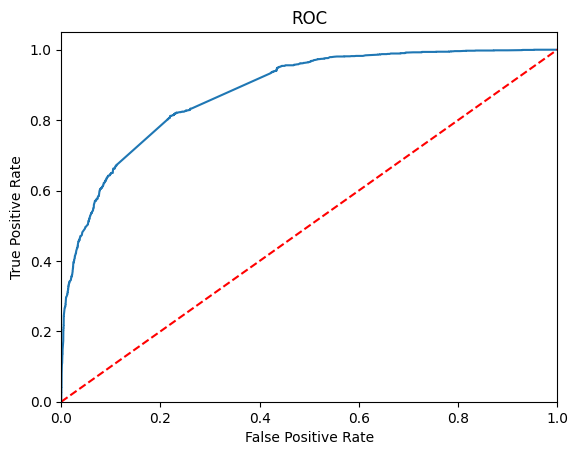

In [24]:
y = train_y
X = x_train_count.astype("float64")

logit_roc_auc = roc_auc_score(y, xgb_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, xgb_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

**Estimation Over Test set**

In [25]:
test_set.head()

,tweet
0,studiolife aislife requires passion dedication...
1,user white supremacist want everyone see new â...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes ð...
4,rd bihday amazing hilarious nephew eli ahmir u...


In [26]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test_set["tweet"])
test_set.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
xgb_model.predict(test_set.astype("float"))[30:35]

array([0, 0, 0, 0, 0])

**Visualisaton**

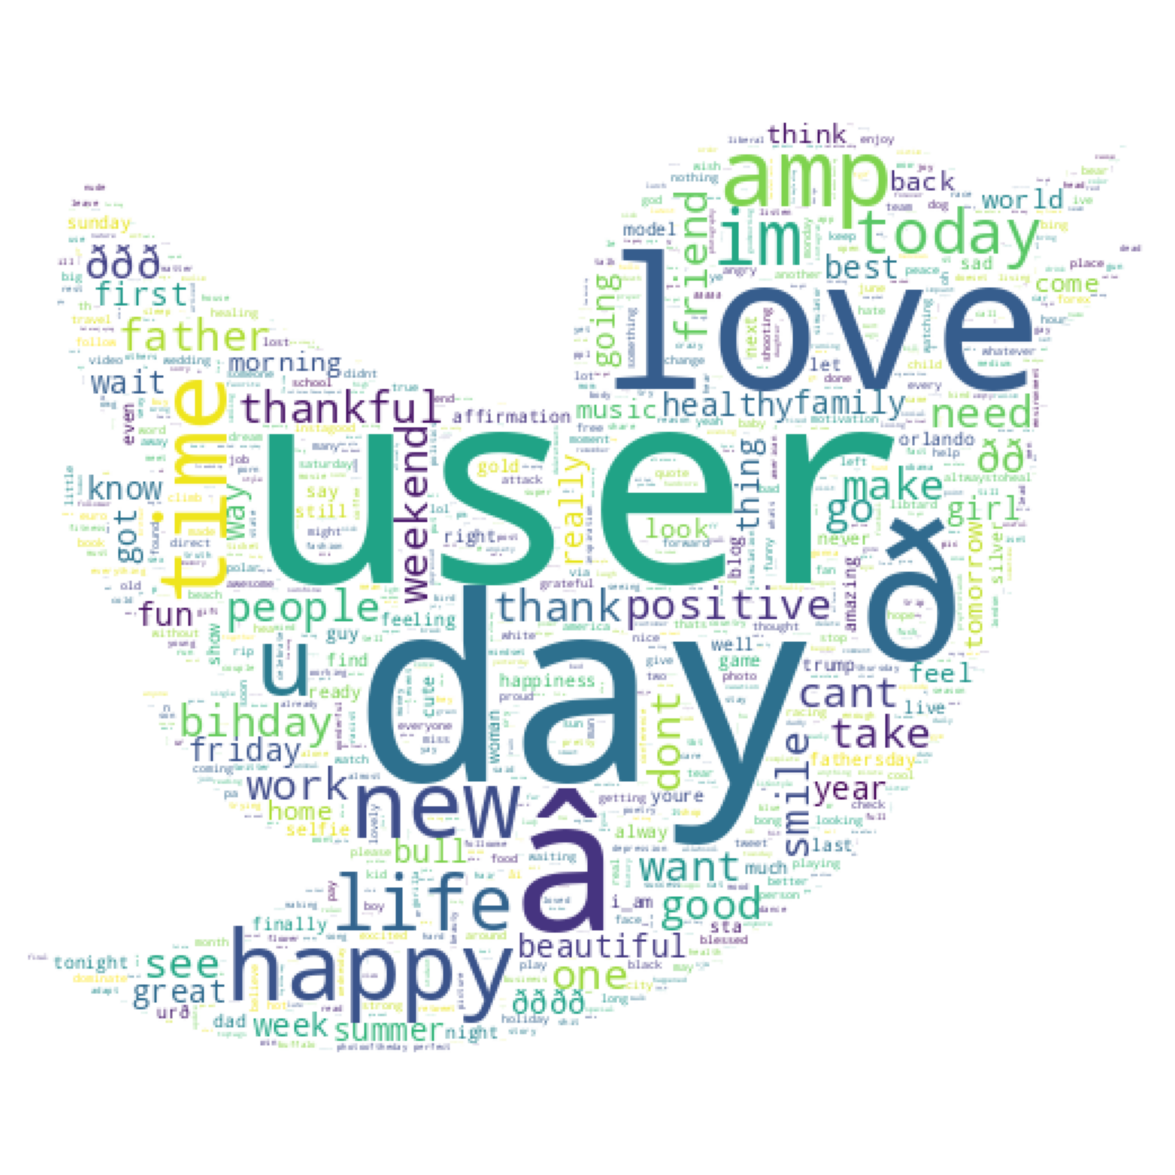

In [28]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

tw_mask = np.array(Image.open('/content/twitter_mask3.jpg'))

text = " ".join(i for i in train_set.tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = tw_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show;